In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import yaml

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.utils import multiclass, class_weight

%matplotlib inline

## Load and Split Data

In [2]:
users = pd.read_csv('../../data/features/shoppers.csv', dtype={'label': int}).set_index('user_id')

In [3]:
users.head()

,n_orders,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,...,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg,label
user_id,,,,,,,,,,,,,,,,,,,,,
1,10,0.0,3.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.271429,0.314286,0.214286,0.057143,0.228571,0.185714,0.000000,0.214286,0.214286,0
2,14,0.0,5.0,5.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.150442,0.261062,0.221239,0.110619,0.256637,0.110619,0.004425,0.013274,0.243363,0
5,4,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.043478,0.304348,0.217391,0.021739,0.021739,0.021739,0.000000,0.000000,0.500000,1
7,20,6.0,5.0,2.0,4.0,0.0,2.0,1.0,0.0,0.0,...,0.079070,0.358140,0.088372,0.065116,0.102326,0.097674,0.000000,0.116279,0.320930,0
8,3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.074627,0.134328,0.149254,0.044776,0.000000,0.014925,0.014925,0.000000,0.552239,3


In [96]:
users['label'].value_counts() / len(users)

6     0.212386
9     0.205779
10    0.147063
1     0.092997
8     0.086023
0     0.068882
5     0.052763
3     0.042047
4     0.040721
2     0.034426
7     0.016912
Name: label, dtype: float64

In [26]:
with open('../../config/model_config.yml') as f:
    config = yaml.load(f)

In [116]:
X = users.drop(columns='label')
X_scaled = preprocessing.scale(X)
Y = users['label']
data = train_test_split(X, X_scaled, Y, **config['split'])
x_train, x_test, x_train_scaled, x_test_scaled, y_train, y_test = data
train_weights = class_weight.compute_sample_weight('balanced', y_train)

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


## Explore Models

### Evaluation

In [63]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Taken from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = multiclass.unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

In [106]:
def evaluate(true, pred):
    acc = accuracy_score(true, pred, normalize=True)
    pre, rec, fs, _ = prf_score(true, pred, average='weighted')
    results = '''\
    Accuracy:    {:0.5f}
    Precision:   {:0.5f}
    Recall:      {:0.5f}
    F-Score:     {:0.5f}
'''.format(acc, pre, rec, fs)
    print(results)
    plt.rcParams['figure.figsize'] = (10,10)
    return plot_confusion_matrix(true, pred, normalize=True)

### Logistic Regression

In [46]:
logit = LogisticRegressionCV(cv=5, random_state=903, multi_class='multinomial').fit(x_train, y_train)

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


KeyboardInterrupt: 

In [35]:
logit_pred = logit.predict(x_test)

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


    Accuracy:    0.36253
    Precision:   0.35131
    Recall:      0.36253
    F-Score:     0.31214



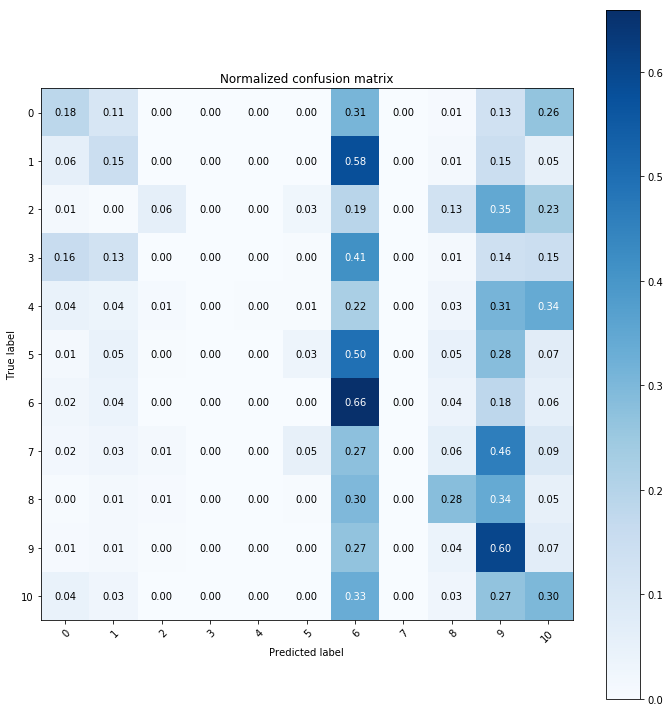

In [107]:
cm = evaluate(y_test, logit_pred)

In [50]:
logit_scaled = LogisticRegressionCV(cv=5, random_state=903, multi_class='multinomial') \
    .fit(preprocessing.scale(x_train), y_train)

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Inc

In [51]:
logit_scaled_pred = logit_scaled.predict(x_test)

    Accuracy:    0.06402
    Precision:   0.06402
    Recall:      0.06402
    F-Score:     0.06402



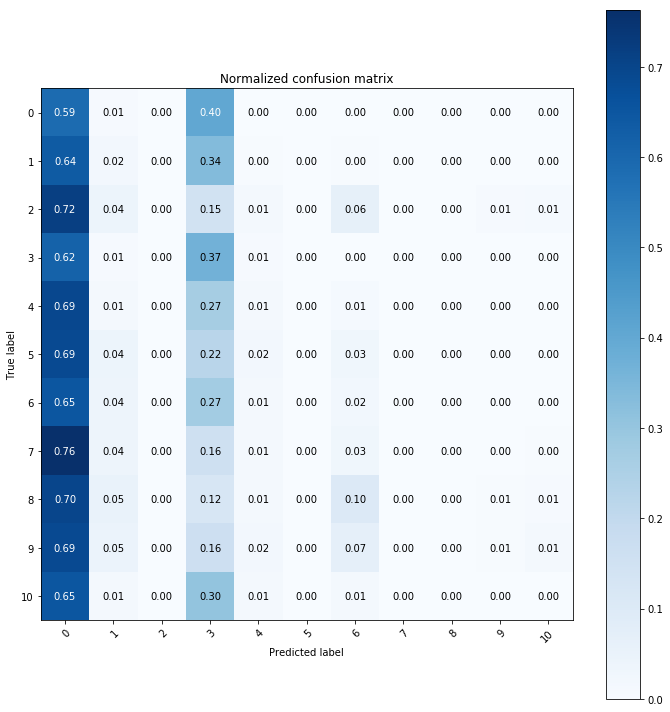

In [87]:
_ = evaluate(y_test, logit_scaled_pred)

### Random Forest

In [10]:
rfc = RandomForestClassifier(random_state=903)

In [90]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rfc_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

In [91]:
rfc_search = RandomizedSearchCV(estimator=rfc, param_distributions=rfc_grid,
                                n_iter=50, cv=3, verbose=2, random_state=903, n_jobs = -1)

In [29]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [88]:
rfc_base = RandomForestClassifier(n_estimators = 100, random_state = 903).fit(x_train, y_train)

    Accuracy:    0.40890
    Precision:   0.40706
    Recall:      0.40890
    F-Score:     0.38982



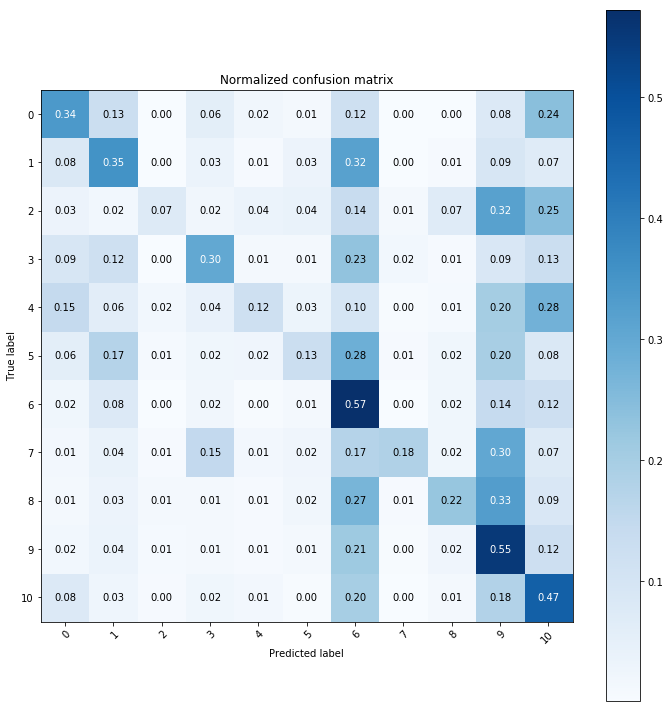

In [108]:
_ = evaluate(y_test, rfc_base.predict(x_test))

In [ ]:
rfc_base_balanced = RandomForestClassifier(n_estimators = 100, random_state = 903, class_weight='balanced') \
    .fit(x_train, y_train)

    Accuracy:    0.40795
    Precision:   0.40806
    Recall:      0.40795
    F-Score:     0.39021



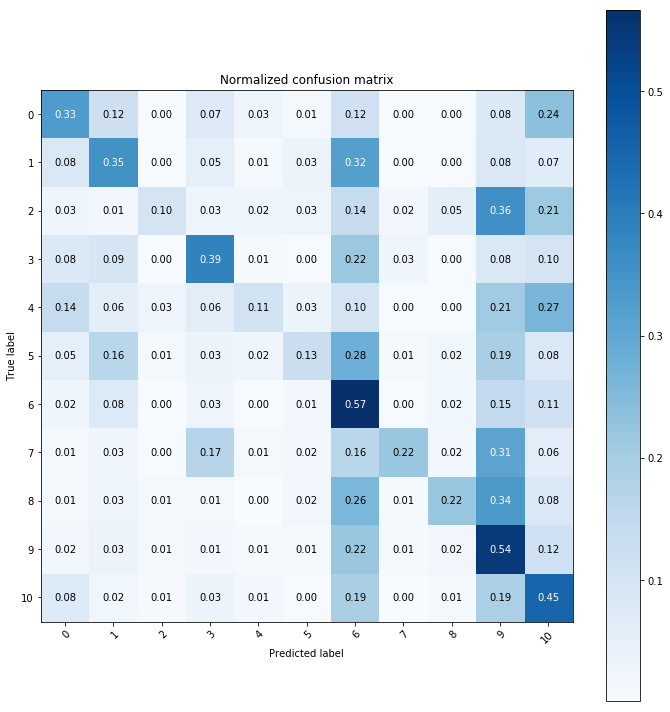

In [110]:
_ = evaluate(y_test, rfc_base_balanced.predict(x_test))

### Linear Support Vector Classifier

    Accuracy:    0.37731
    Precision:   0.38175
    Recall:      0.37731
    F-Score:     0.33350



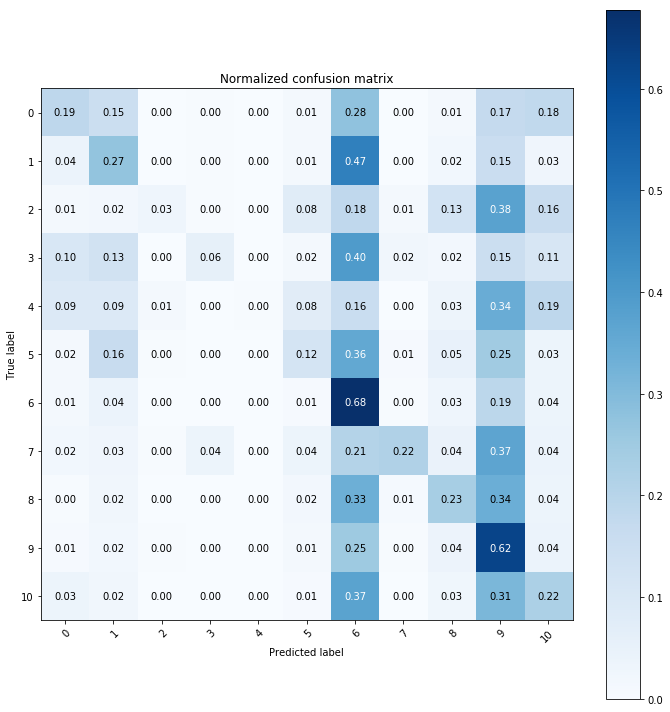

In [111]:
_ = evaluate(y_test, LinearSVC(dual=False, random_state=903).fit(x_train, y_train).predict(x_test))

    Accuracy:    0.35866
    Precision:   0.39787
    Recall:      0.35866
    F-Score:     0.35816



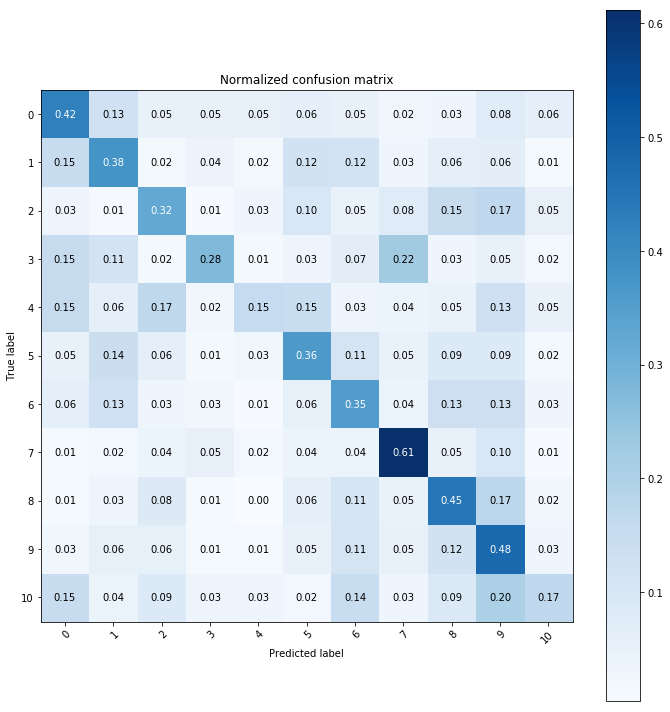

In [112]:
_ = evaluate(y_test, LinearSVC(dual=False, random_state=903, class_weight='balanced') \
             .fit(x_train, y_train).predict(x_test))

    Accuracy:    0.37725
    Precision:   0.38138
    Recall:      0.37725
    F-Score:     0.33361



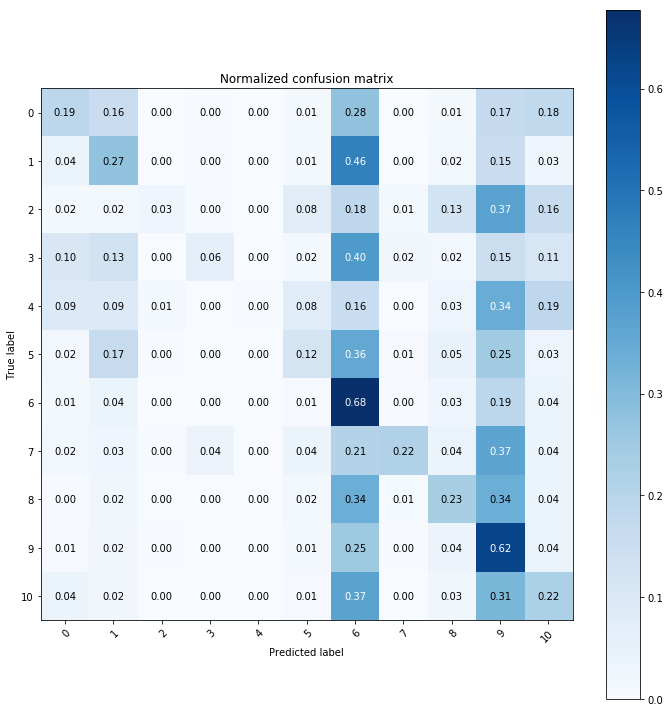

In [113]:
_ = evaluate(y_test, LinearSVC(dual=False, random_state=903) \
             .fit(x_train_scaled, y_train).predict(x_test_scaled))

    Accuracy:    0.35847
    Precision:   0.39775
    Recall:      0.35847
    F-Score:     0.35807



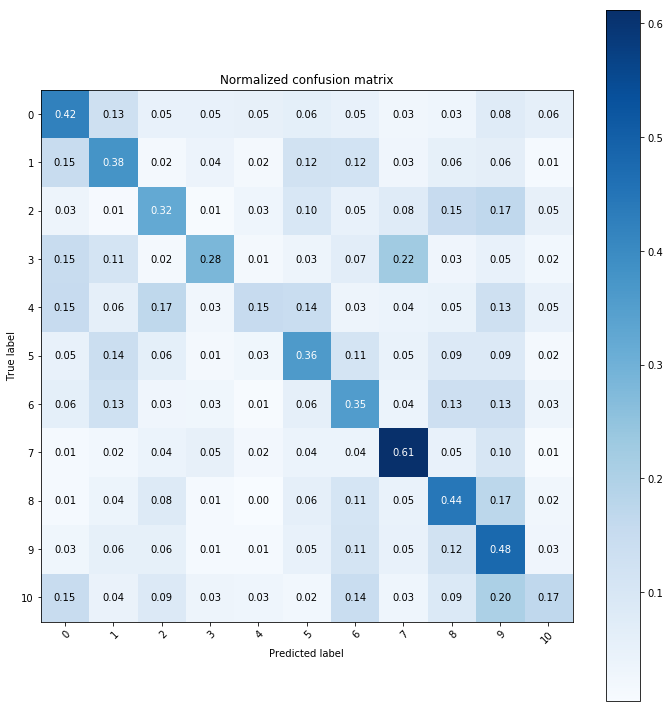

In [114]:
_ = evaluate(y_test, LinearSVC(dual=False, random_state=903, class_weight='balanced') \
             .fit(x_train_scaled, y_train).predict(x_test_scaled))

### Gradient Boosting

In [117]:
gb_base = GradientBoostingClassifier(random_state=903, max_features='sqrt')
gb_base.fit(x_train, y_train, sample_weight=train_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=903,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

    Accuracy:    0.36110
    Precision:   0.43675
    Recall:      0.36110
    F-Score:     0.37265



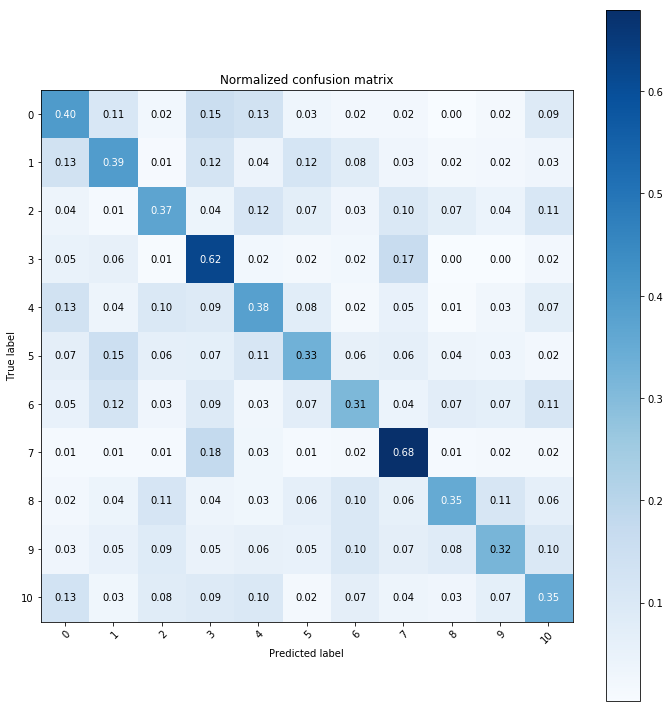

In [118]:
_ = evaluate(y_test, gb_base.predict(x_test))

## PCA

In [4]:
users.columns

Index(['n_orders', 'n_dow_0', 'n_dow_1', 'n_dow_2', 'n_dow_3', 'n_dow_4',
       'n_dow_5', 'n_dow_6', 'n_hod_0', 'n_hod_1', 'n_hod_2', 'n_hod_3',
       'n_hod_4', 'n_hod_5', 'n_hod_6', 'n_hod_7', 'n_hod_8', 'n_hod_9',
       'n_hod_10', 'n_hod_11', 'n_hod_12', 'n_hod_13', 'n_hod_14', 'n_hod_15',
       'n_hod_16', 'n_hod_17', 'n_hod_18', 'n_hod_19', 'n_hod_20', 'n_hod_21',
       'n_hod_22', 'n_hod_23', 'order_size_mean', 'order_size_std',
       'order_size_amax', 'order_size_amin', 'small', 'medium', 'large', 'xl',
       'days_since_prior_order', 'reordered', 'organic', 'popular', 'prepared',
       'dairy', 'gluten', 'snack', 'meat', 'fish', 'beverage', 'veg', 'label'],
      dtype='object')

In [42]:
from sklearn import decomposition as decomp
import seaborn as sns
from sklearn.model_selection import cross_val_score


In [48]:
feats = users.drop(columns=['label', 'n_orders'])
x = preprocessing.scale(feats)
fa = decomp.FactorAnalysis(max_iter=2500)
pca = decomp.PCA(svd_solver='full')

In [50]:
pca_scores = []
fa_scores = []
for n in np.arange(0, len(feats.columns), 7):
    pca.n_components = n
    fa.n_components = n
    pca_scores.append(np.mean(cross_val_score(pca, x, cv=5)))
    fa_scores.append(np.mean(cross_val_score(fa, x, cv=5)))


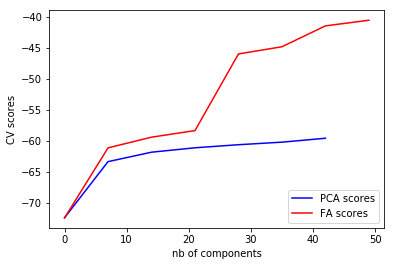

In [52]:
plt.figure()
plt.plot(np.arange(0, len(feats.columns), 7), pca_scores, 'b', label='PCA scores')
plt.plot(np.arange(0, len(feats.columns), 7), fa_scores, 'r', label='FA scores')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.show()

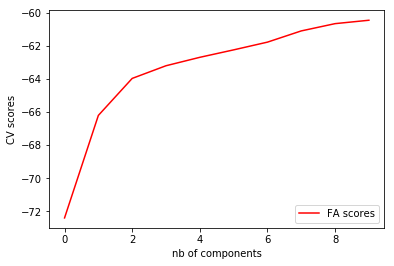

In [53]:
fa_scores = []
for n in range(10):
    fa.n_components = n
    fa_scores.append(np.mean(cross_val_score(fa, x, cv=5)))
plt.figure()
plt.plot(range(10), fa_scores, 'r', label='FA scores')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.show()

In [56]:
fa = decomp.FactorAnalysis(n_components=4, random_state=903, max_iter=2500)
fa.fit(x)

FactorAnalysis(copy=True, iterated_power=3, max_iter=2500, n_components=4,
        noise_variance_init=None, random_state=903,
        svd_method='randomized', tol=0.01)

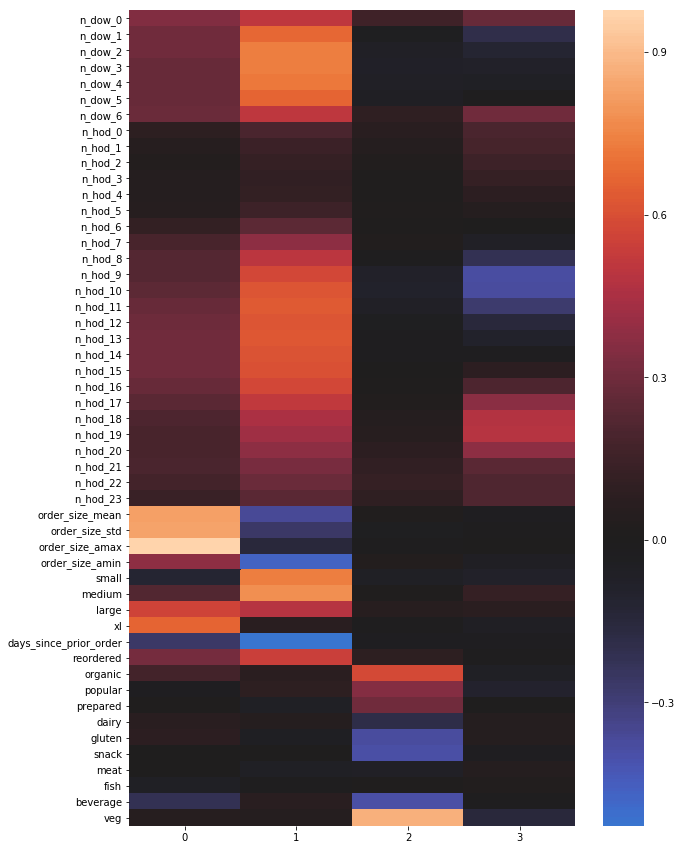

In [58]:
fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(fa.components_.T, ax=ax, yticklabels=feats.columns, center=0)

In [60]:
pd.DataFrame(fa.components_, columns=feats.columns)

,n_dow_0,n_dow_1,n_dow_2,n_dow_3,n_dow_4,n_dow_5,n_dow_6,n_hod_0,n_hod_1,n_hod_2,...,organic,popular,prepared,dairy,gluten,snack,meat,fish,beverage,veg
0,0.346786,0.304094,0.297364,0.281050,0.278101,0.273481,0.288778,0.087532,0.051563,0.035575,...,0.173493,-0.022582,0.008700,0.064742,0.080617,-0.002615,0.002791,-0.051994,-0.218456,0.053103
1,0.504711,0.675985,0.733433,0.735604,0.723242,0.661092,0.504377,0.191719,0.138404,0.114002,...,0.077538,0.089338,-0.057320,0.036927,-0.043341,0.005556,-0.057372,-0.016181,0.065386,0.042087
2,0.157269,-0.038258,-0.068843,-0.070254,-0.064682,-0.046441,0.100022,0.071748,0.047959,0.029924,...,0.585183,0.348363,0.296741,-0.184210,-0.373579,-0.389221,-0.066717,0.012299,-0.389469,0.871181
3,0.278739,-0.189031,-0.111407,-0.079609,-0.056154,-0.014469,0.302275,0.199784,0.180340,0.142593,...,-0.054331,-0.093062,-0.000201,0.037764,0.047930,-0.022661,0.046481,0.026576,-0.011710,-0.150053
